In [ ]:
# Cell 1: 라이브러리 임포트 및 설정
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from est_utils import FONT_PROP, BACKBONE_CLASSES

# MLflow 트래킹 서버 URI 설정
mlflow.set_tracking_uri("http://0.0.0.0:5000")

# 분석할 MLflow Experiment 이름 또는 ID
EXPERIMENT_NAME = "FER Fine-tuning with Soft Labels"

# 분석할 Run ID 목록 (예시: 여러 훈련 실행을 비교할 경우)
# run_ids = ["run_id_1", "run_id_2"]
# 단일 Run을 분석할 경우:
TARGET_RUN_ID = "fcc0807a25784362868877b32743a3fc" # 여기에 분석하고자 하는 run_id를 입력하세요.

# 지표 및 아티팩트 이름
METRICS_TO_ANALYZE = ["train_loss", "val_loss", "general_val_loss", "general_val_accuracy", "test_accuracy", "test_f1_macro"]
ARTIFACT_NAME = "./output/08_test_confusion_matrix.png" # 08_finetuning_refactored.py에서 저장된 혼동 행렬 이미지 이름

--- Analysis for Run: fine_tuning_run_2 (fcc0807a25784362868877b32743a3fc) ---
Parameters:
  model_name: HardlyHumans/Facial-expression-detection
  learning_rate: 5e-06
  epochs: 5
  batch_size: 16
  train_csv_path: 06_softlabel_dataset_resplit.csv
  general_val_csv_path: 07_general_val_set.csv
  mlflow_tracking_uri: http://0.0.0.0:5000
  mlflow_experiment_name: FER Fine-tuning with Soft Labels
  mlflow_run_name: fine_tuning_run_2
  patience: 3
  min_delta: 0.001
Metrics:
  train_loss: 0.2773
  val_loss: 0.4092
  general_val_loss: 1.3501
  general_val_accuracy: 0.5637
  test_accuracy: 0.7008
  test_f1_macro: 0.6097


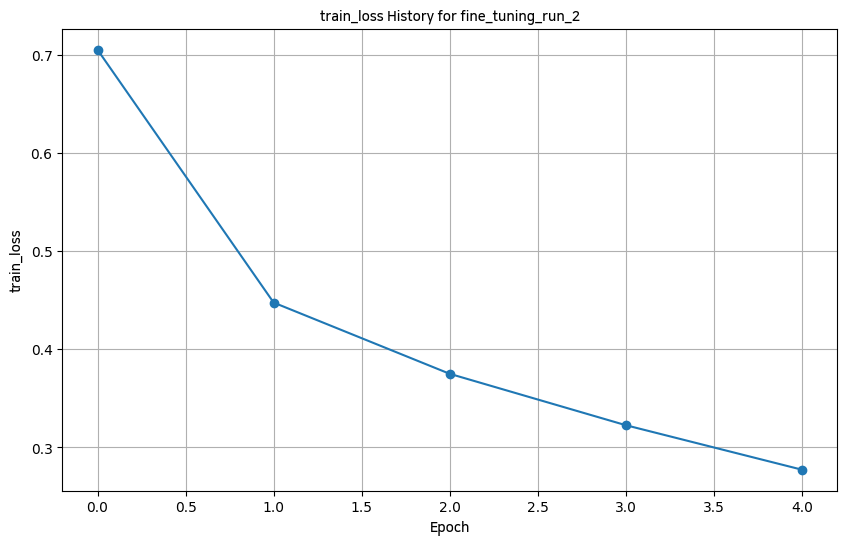

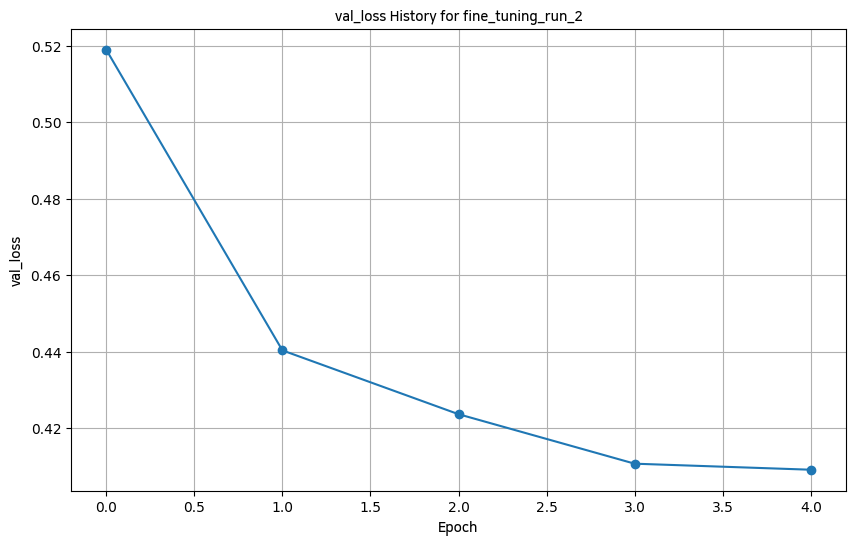

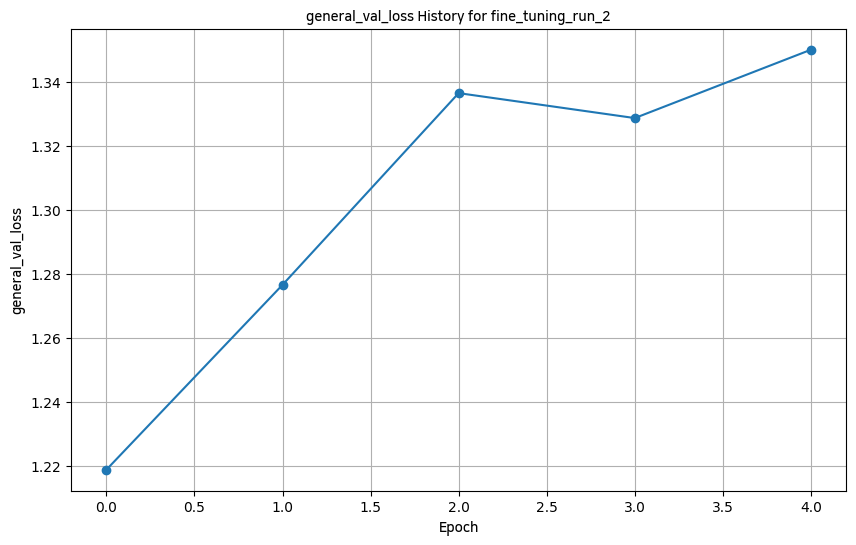

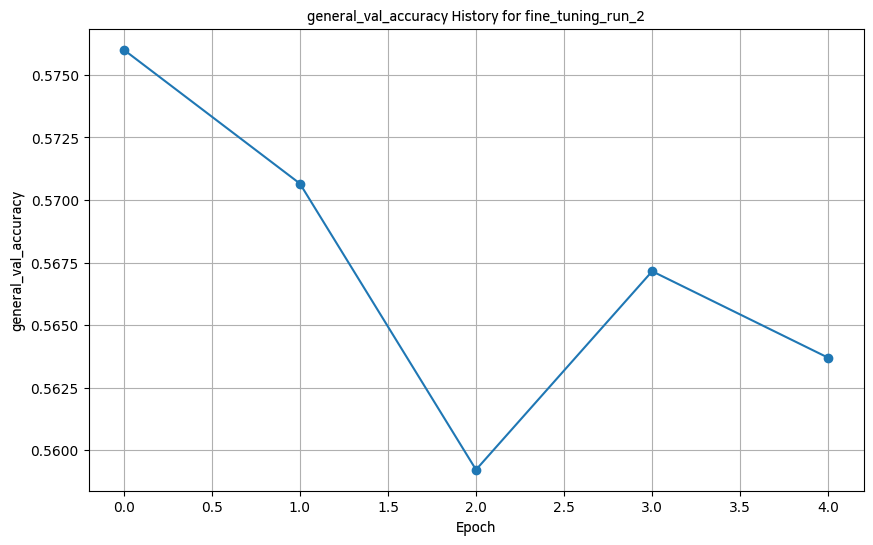

Artifact downloaded to: /tmp/tmpj5pp1nfj/08_test_confusion_matrix.png


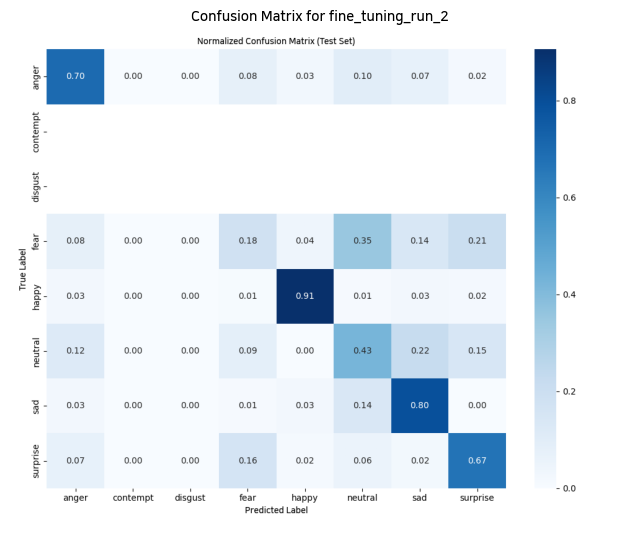

In [ ]:
# Cell 2: MLflow Run 정보 및 지표 가져오기
def get_run_metrics(run_id, metrics_list):
    client = mlflow.tracking.MlflowClient()
    run = client.get_run(run_id)
    metrics = {metric: run.data.metrics.get(metric) for metric in metrics_list}
    params = run.data.params
    return metrics, params, run.info.run_name

# 단일 Run 분석 예시
if TARGET_RUN_ID:
    metrics, params, run_name = get_run_metrics(TARGET_RUN_ID, METRICS_TO_ANALYZE)
    print(f"--- Analysis for Run: {run_name} ({TARGET_RUN_ID}) ---")
    print("Parameters:")
    for k, v in params.items():
        print(f"  {k}: {v}")
    print("Metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")

    # 모든 시계열 지표에 대해 에포크별 변화 시각화
    client = mlflow.tracking.MlflowClient()
    for metric_name in METRICS_TO_ANALYZE[:4]:
        history_metrics = client.get_metric_history(TARGET_RUN_ID, metric_name)
        if history_metrics:
            epochs = [m.step for m in history_metrics]
            values = [m.value for m in history_metrics]
            plt.figure(figsize=(10, 6))
            plt.plot(epochs, values, marker='o')
            plt.title(f'{metric_name} History for {run_name}', fontproperties=FONT_PROP)
            plt.xlabel('Epoch', fontproperties=FONT_PROP)
            plt.ylabel(metric_name, fontproperties=FONT_PROP)
            plt.grid(True)            
            plt.savefig(f'./output/09_{metric_name}_run{run_name[-1]}.png')
            plt.show()

    # 아티팩트 다운로드 및 표시 (예: 혼동 행렬 이미지)
    try:
        artifact_path = client.download_artifacts(TARGET_RUN_ID, ARTIFACT_NAME)
        print(f"Artifact downloaded to: {artifact_path}")
        img = plt.imread(artifact_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Confusion Matrix for {run_name}', fontproperties=FONT_PROP)
        plt.show()
    except Exception as e:
        print(f"Error downloading or displaying artifact {ARTIFACT_NAME}: {e}")
else:
    print("분석할 TARGET_RUN_ID를 설정해 주세요.")